In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from src.tennis import TenisSimulation

# Aplicação de Cadeias de Markov na Simulação de um Jogo de Tênis

O trabalho em questão consistem na simulação de uma partida de tênis utilizando cadeias de Markov para simular o processo estocástico inerente ao jogo.

A chance de um jogador sair vitorioso de uma partida de tênis está diretamente relacionado com a sua habilidade no esporte. Portanto, sintetizamos as aptidões e habilidades de um jogador através de uma representação numérica(p) que varia no intervalo [0, 1], sendo 0 uma baixa aptidão e 1 um jogador extremamente habilidoso. Neste ponto, p representa a probabilidade do jogador ganhar o ponto, isto é, se o jogador A possúi uma probabilidade p de marcar o ponto, o jogador B deve possuir um valor de habilidade de q = 1 - p.


## Representação da cadeia de Markov

A representação de um game dentro de um set foi elaborada utilizando a cadeia logo abaixo. Note que, diferente da cadeia proposta originalmente a implementalção apresenta os estados "30-30", "30-40" e "40-30" a mais, buscando-se uma representação mais fiel do game.

<img src="imgs/chain.jpeg" width=500>
<p>
Imagem retirada da internet, <a href="https://twitter.com/Vestige_du_jour/status/1052322461688061952">referência</a>.
</p>

## Partida 1

A primeira simulação leva em conta um jogador A muito mais habilidoso do que o adversário B. Isto é, utiliza-se um valor de p relativamente maior do que q. A proposta do trabalho consiste na escolha de p dentro do seguinte intervalo, 0,70 <= p <= 0,80, portanto, escolheu-se um valor intermediário de p = 0.75.

In [120]:
# Gera os dados da simulação
n_sample = 10000
probability = 0.75

tennis_df = TenisSimulation.generate_dataset(probability, n_sample)
tennis_df.to_parquet(f'datasets/{n_sample}_probability_{probability}.parquet.gzip')

100%|██████████| 10000/10000 [00:02<00:00, 4948.53it/s]


O dataset gerado consiste em um DataFrame com n_sample simulações. Para cada simulação, salva-se os dados da quantidade de pontos, sets ganhos e games ganhos por cada jogador além da quantidade de deuces e o vencedor da partida. O dataset pode ser visto logo abaixo:

In [121]:
tennis_df

,A scored,B scored,sets A-Wins,sets B-Wins,games A-Wins,games B-Wins,deuce,Winner
0,50,14,2,0,12,0,2,A
1,51,16,2,0,12,1,1,A
2,54,27,2,0,12,1,4,A
3,49,17,2,0,12,0,1,A
4,53,17,2,0,12,0,5,A
...,...,...,...,...,...,...,...,...
9995,48,10,2,0,12,0,0,A
9996,52,15,2,0,12,0,4,A
9997,54,21,2,0,12,1,4,A
9998,53,20,2,0,12,2,1,A


Como a probabilidade p esta diretamente ligada com a chance do jogador A marcar um ponto, é de nosso interesse observar o gráfico de distribuição de probabilidade para os pontos marcados durante os jogos. Portanto, o gráfico abaixo mostra tanto a distribuição de A quanto de B.

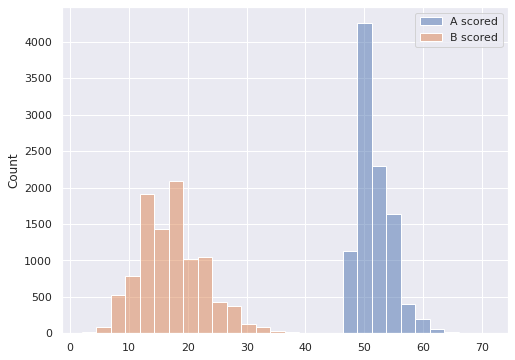

In [122]:
sns.set_theme()
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.histplot(data=tennis_df.loc[:, ['A scored', 'B scored']], ax=ax);

Nota-se que os pontos marcados por A foram muito mais elavados, como era de se esperar devido ao alto valor de p. É interessante observamos que a distribuição de B se assemelha muito com uma distribuição normal, entretanto, por apresentar uma baixa média de pontos marcados esta deslocada para esquerda em relação à A, logo, podemos imaginar que distribuição de A também se trata de uma normal com um alto valor de curtose.

Iremos calcular alguns valores estatísticos para critério de comparação e inferência da simulação executada. Portanto, fazemos a análise utilizando 3 jogos como conjunto amostral, isto é, dividimos o dataset em grupos de 3 e para cada grupo inferimos os dados.

In [123]:
tennis_va3_dict = { 
    'A': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
    'B': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
}

for i in range(0, n_sample//3):
    tennis_va3_dict['A']['matches'].append(sum(tennis_df.iloc[i*3:i*3+3, :]['Winner'] == 'A'))
    tennis_va3_dict['B']['matches'].append(sum(tennis_df.iloc[i*3:i*3+3, :]['Winner'] == 'B'))

    tennis_va3_dict['A']['scored'].append(sum(tennis_df.loc[i*3:i*3+2, 'A scored']))
    tennis_va3_dict['B']['scored'].append(sum(tennis_df.loc[i*3:i*3+2, 'B scored']))

    tennis_va3_dict['A']['games'].append(sum(tennis_df.loc[i*3:i*3+2, 'games A-Wins']))
    tennis_va3_dict['B']['games'].append(sum(tennis_df.loc[i*3:i*3+2, 'games B-Wins']))

    tennis_va3_dict['A']['sets'].append(sum(tennis_df.loc[i*3:i*3+2, 'sets A-Wins']))
    tennis_va3_dict['B']['sets'].append(sum(tennis_df.loc[i*3:i*3+2, 'sets B-Wins']))

In [124]:
tennis_va3_df = {
    'A': {
        'matches': pd.DataFrame(tennis_va3_dict['A']['matches']),
        'scored': pd.DataFrame(tennis_va3_dict['A']['scored']),
        'games': pd.DataFrame(tennis_va3_dict['A']['games']),
        'sets': pd.DataFrame(tennis_va3_dict['A']['sets'])
    },
    'B': {
        'matches': pd.DataFrame(tennis_va3_dict['B']['matches']),
        'scored': pd.DataFrame(tennis_va3_dict['B']['scored']),
        'games': pd.DataFrame(tennis_va3_dict['B']['games']),
        'sets': pd.DataFrame(tennis_va3_dict['B']['sets'])
    }}

In [125]:
# Média
tennis_va3_mean = {
    'A': [np.mean(i) for i in tennis_va3_dict['A'].values()],
    'B': [np.mean(i) for i in tennis_va3_dict['B'].values()]
}

tennis_va3_mean = pd.DataFrame(tennis_va3_mean).transpose()
tennis_va3_mean.columns = ['matches_mean', 'scored_mean', 'games_mean', 'sets_mean']
display(tennis_va3_mean)

# Desvio padrão
tennis_va3_std = {
    'A': [np.std(i) for i in tennis_va3_dict['A'].values()],
    'B': [np.std(i) for i in tennis_va3_dict['B'].values()]
}

tennis_va3_std = pd.DataFrame(tennis_va3_std).transpose()
tennis_va3_std.columns = ['matches_std', 'scored_std', 'games_std', 'sets_std']
display(tennis_va3_std)

,matches_mean,scored_mean,games_mean,sets_mean
A,3.0,155.172517,36.000300,6.0
B,0.0,51.892889,1.978098,0.0


,matches_std,scored_std,games_std,sets_std
A,0.0,5.058784,0.017319,0.0
B,0.0,9.749530,1.424087,0.0


Observa-se que o jogador A ganhou em média as 3 partidas do grupo, como era esperado devido ao alto valor de p, consequentemente, A marcou em média muito mais pontos o que levou a mais games ganhos do que B.

Os desvios padrões nos mostram que os valores foram bem consistentes, existiram games em que saiu B vitorioso, entretanto, como foram outliers dentro do conjunto de dados nem mesmo afetaram o resultado final da média.

A média acumulada consiste no cálculo da média expandindo o grupo, logo, é uma medida interessante para analisar a convergência da média em relação ao tamanho da amostra utilizada.

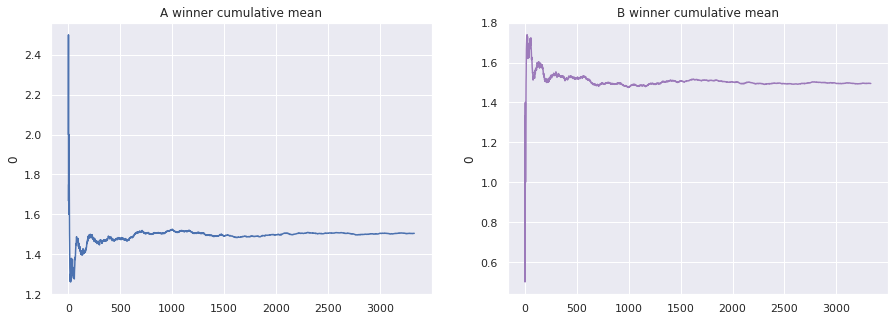

In [126]:
# Gráfico da média acumulada
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('A winner cumulative mean')
sns.lineplot(data=tennis_va3_df_dict['A']['matches'].expanding().mean().iloc[:, 0], ax=ax[0]);

ax[1].set_title('B winner cumulative mean')
sns.lineplot(data=tennis_va3_df_dict['B']['matches'].expanding().mean().iloc[:, 0], ax=ax[1], color='#9C7ABA');

Vemos que a média acumulada permaneceu constante durante todo período o que sinifica que os dados são muito estáveis e possuem baixa variação, mesmo aumentando o conjunto de dados os valores de média para os jogos ganhos não se alteram.

Uma forma de analisar a dispersão dos dados é através do boxplot, sendo um gráfico capaz de sintetizar um grande conjunto de informações quanto a distribuição dos dados. Portanto, geramos o boxplot para alguns dados interessantes.

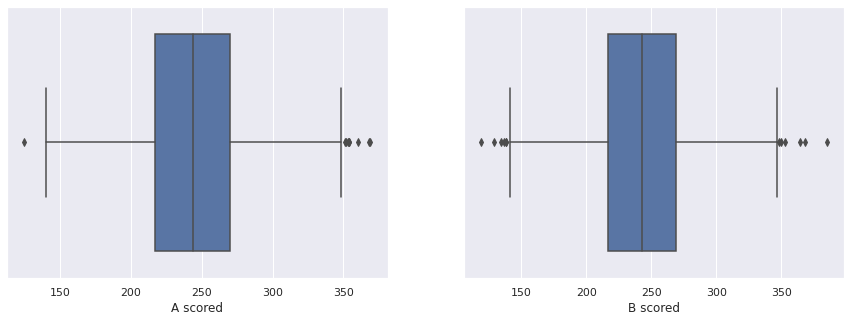

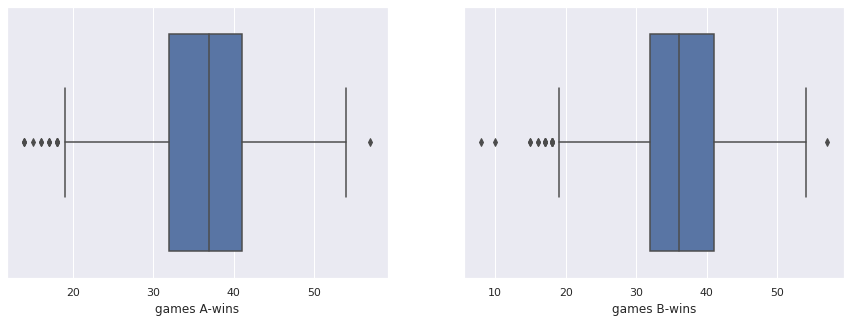

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va3_df_dict['A']['scored'][0], ax=ax[0]);
ax[0].set_xlabel('A scored')
sns.boxplot(x=tennis_va3_df_dict['B']['scored'][0], ax=ax[1]);
ax[1].set_xlabel('B scored')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va3_df_dict['A']['games'][0], ax=ax[0]);
ax[0].set_xlabel('games A-wins')
sns.boxplot(x=tennis_va3_df_dict['B']['games'][0], ax=ax[1]);
ax[1].set_xlabel('games B-wins');

Observamos que a quantidade de pontos marcados por A e B apresentam sim um valor de dispersão, ainda que baixo, essa afirmação se dá pelo fato do quartil inferior ser próximo do quartil superior, isto é, ambos gráficos possuem uma baixa amplitude interquartílica.

Enquanto para os games, vemos que A ganhou consistentemente, como era de se esperar pelos dados supracitados. Nota-se também que B realmente ganhou alguns poucos games.

In [128]:
def percentage(data_a: pd.DataFrame, data_b: pd.DataFrame):
    data_a = data_a.sum()
    data_b = data_b.sum()
    return (data_a) / (data_a + data_b)

percentages = {}

percentages['scored'] = {
    'A': percentage(tennis_va3_df_dict['A']['scored'][0], tennis_va3_df_dict['B']['scored'][0]),
    'B': percentage(tennis_va3_df_dict['B']['scored'][0], tennis_va3_df_dict['A']['scored'][0])
}
percentages['games'] = {
    'A': percentage(tennis_va3_df_dict['A']['games'][0], tennis_va3_df_dict['B']['games'][0]),
    'B': percentage(tennis_va3_df_dict['B']['games'][0], tennis_va3_df_dict['A']['games'][0])
}
percentages['sets'] = {
    'A': percentage(tennis_va3_df_dict['A']['sets'][0], tennis_va3_df_dict['B']['sets'][0]),
    'B': percentage(tennis_va3_df_dict['B']['sets'][0], tennis_va3_df_dict['A']['sets'][0])
}
percentages['matches'] = {
    'A': percentage(tennis_va3_df_dict['A']['matches'][0], tennis_va3_df_dict['B']['matches'][0]),
    'B': percentage(tennis_va3_df_dict['B']['matches'][0], tennis_va3_df_dict['A']['matches'][0])
}

percentages_df = pd.DataFrame(percentages)
percentages_df

,scored,games,sets,matches
A,0.500409,0.501002,0.50054,0.50155
B,0.499591,0.498998,0.49946,0.49845


Sintetizamos os resultados pela porcentagem de cada jogador dentre as etapas de uma partida de tênis. Observamos que A possúi uma larga vantagem em B, represetando que a simulação foi consistente em todas as etapas.

### VA com espaço amostral de 10 partidas

Os testes anteriores foram refeitos considerando uma variável aleatória com um espaço amostral de 10 partidas. Portanto, sorteamos tantos conjuntos de 10 partidas quanto possível, utilizando dados aleatórios com distribuição uniforme no sorteamento.

In [129]:
tennis_va10_dict = { 
    'A': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
    'B': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
}

samples = np.random.randint(0, n_sample//10, (n_sample//10, 10))

for i in range(0, n_sample//10):
    tennis_va10_dict['A']['matches'].append(sum(tennis_df.iloc[samples[i], :]['Winner'] == 'A'))
    tennis_va10_dict['B']['matches'].append(sum(tennis_df.iloc[samples[i], :]['Winner'] == 'B'))

    tennis_va10_dict['A']['scored'].append(sum(tennis_df.loc[samples[i], 'A scored']))
    tennis_va10_dict['B']['scored'].append(sum(tennis_df.loc[samples[i], 'B scored']))

    tennis_va10_dict['A']['games'].append(sum(tennis_df.loc[samples[i], 'games A-Wins']))
    tennis_va10_dict['B']['games'].append(sum(tennis_df.loc[samples[i], 'games B-Wins']))

    tennis_va10_dict['A']['sets'].append(sum(tennis_df.loc[samples[i], 'sets A-Wins']))
    tennis_va10_dict['B']['sets'].append(sum(tennis_df.loc[samples[i], 'sets B-Wins']))

In [130]:
tennis_va10_df_dict = {
    'A': {
        'matches': pd.DataFrame(tennis_va10_dict['A']['matches']),
        'scored': pd.DataFrame(tennis_va10_dict['A']['scored']),
        'games': pd.DataFrame(tennis_va10_dict['A']['games']),
        'sets': pd.DataFrame(tennis_va10_dict['A']['sets'])
    },
    'B': {
        'matches': pd.DataFrame(tennis_va10_dict['B']['matches']),
        'scored': pd.DataFrame(tennis_va10_dict['B']['scored']),
        'games': pd.DataFrame(tennis_va10_dict['B']['games']),
        'sets': pd.DataFrame(tennis_va10_dict['B']['sets'])
    }}

In [131]:
# Média
tennis_va10_mean = {
    'A': [np.mean(i) for i in tennis_va10_dict['A'].values()],
    'B': [np.mean(i) for i in tennis_va10_dict['B'].values()]
}

tennis_va10_mean = pd.DataFrame(tennis_va10_mean).transpose()
tennis_va10_mean.columns = ['matches_mean', 'scored_mean', 'games_mean', 'sets_mean']
display(tennis_va10_mean)

# Desvio padrão
tennis_va10_std = {
    'A': [np.std(i) for i in tennis_va10_dict['A'].values()],
    'B': [np.std(i) for i in tennis_va10_dict['B'].values()]
}

tennis_va10_std = pd.DataFrame(tennis_va10_std).transpose()
tennis_va10_std.columns = ['matches_std', 'scored_std', 'games_std', 'sets_std']
display(tennis_va10_std)

,matches_mean,scored_mean,games_mean,sets_mean
A,10.0,516.931,120.000,20.0
B,0.0,172.723,6.526,0.0


,matches_std,scored_std,games_std,sets_std
A,0.0,9.430283,0.000000,0.0
B,0.0,18.278465,2.704316,0.0


Da média e do desvio padrão, vemos que o número de matches foi constante, isto é, A continuou ganhando consistemente de B. Embora a quantidade de pontos que B marcou durante as partidas foi ligeiramente maior, devemos nos atentar que estão sendo utilizados 10 jogos como critério de análise, portanto, a quantidade é factível e esperada pela análise de conjunto com espaço amostral de 3 partidas.

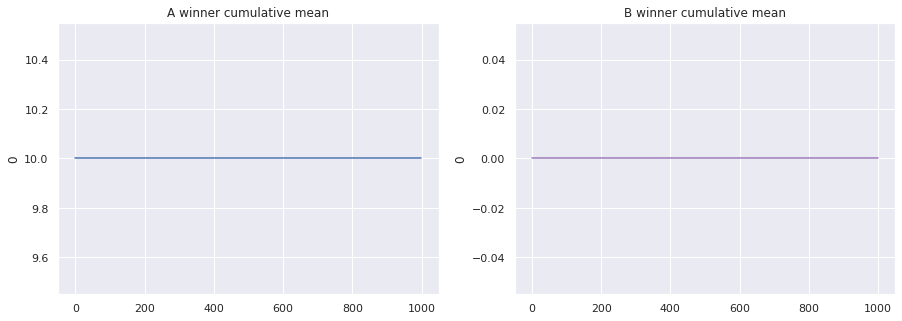

In [132]:
# Gráfico da média acumulada
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('A winner cumulative mean')
sns.lineplot(data=tennis_va10_df_dict['A']['matches'].expanding().mean().iloc[:, 0], ax=ax[0]);

ax[1].set_title('B winner cumulative mean')
sns.lineplot(data=tennis_va10_df_dict['B']['matches'].expanding().mean().iloc[:, 0], ax=ax[1], color='#9C7ABA');

Vemos que a média acumulada permaneceu a mesma, uma vez que a média e desvio padrão não sofreram nenhuma alteração notável.

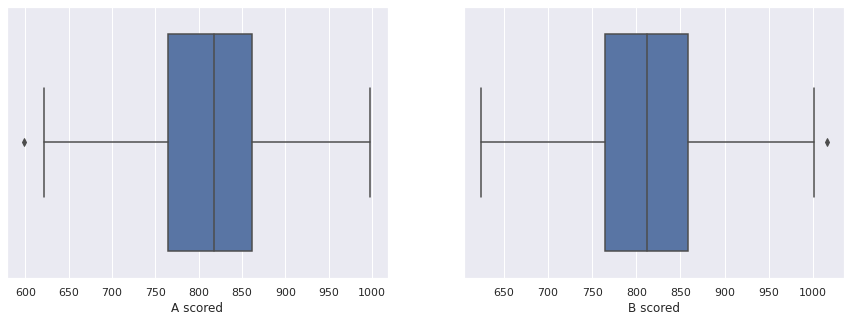

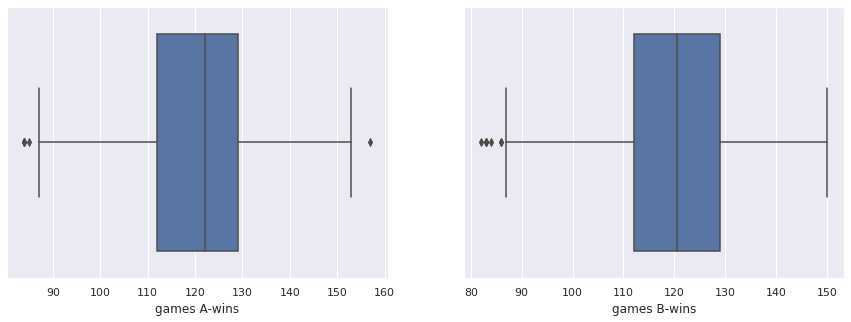

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va10_df_dict['A']['scored'][0], ax=ax[0]);
ax[0].set_xlabel('A scored')
sns.boxplot(x=tennis_va10_df_dict['B']['scored'][0], ax=ax[1]);
ax[1].set_xlabel('B scored')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va10_df_dict['A']['games'][0], ax=ax[0]);
ax[0].set_xlabel('games A-wins')
sns.boxplot(x=tennis_va10_df_dict['B']['games'][0], ax=ax[1]);
ax[1].set_xlabel('games B-wins');

Do boxplot é interessante notarmos que devido a uma quantidade maior de partidas o número de outliers diminuiu, isto é, obtemos resultados muito mais consistentes ao considerar um espaço amostral de tamanho 10.

In [134]:
def percentage(data_a: pd.DataFrame, data_b: pd.DataFrame):
    data_a = data_a.sum()
    data_b = data_b.sum()
    return (data_a) / (data_a + data_b)

percentages = {}

percentages['scored'] = {
    'A': percentage(tennis_va10_df_dict['A']['scored'][0], tennis_va10_df_dict['B']['scored'][0]),
    'B': percentage(tennis_va10_df_dict['B']['scored'][0], tennis_va10_df_dict['A']['scored'][0])
}
percentages['games'] = {
    'A': percentage(tennis_va10_df_dict['A']['games'][0], tennis_va10_df_dict['B']['games'][0]),
    'B': percentage(tennis_va10_df_dict['B']['games'][0], tennis_va10_df_dict['A']['games'][0])
}
percentages['sets'] = {
    'A': percentage(tennis_va10_df_dict['A']['sets'][0], tennis_va10_df_dict['B']['sets'][0]),
    'B': percentage(tennis_va10_df_dict['B']['sets'][0], tennis_va10_df_dict['A']['sets'][0])
}
percentages['matches'] = {
    'A': percentage(tennis_va10_df_dict['A']['matches'][0], tennis_va10_df_dict['B']['matches'][0]),
    'B': percentage(tennis_va10_df_dict['B']['matches'][0], tennis_va10_df_dict['A']['matches'][0])
}

percentages_df = pd.DataFrame(percentages)
percentages_df

,scored,games,sets,matches
A,0.749551,0.948422,1.0,1.0
B,0.250449,0.051578,0.0,0.0


As porcentagens não tiveram alterações notáveis.

## Partida 2

A segunda simulação leva em jogadores com níveis técnicos semelhantes. Isto é, utiliza-se um valor de p próximo de q. A segunda partida consiste na escolha de p dentro do seguinte intervalo, 0,45 <= p <= 0,55, portanto, escolheu-se um valor intermediário de p = 0.50.

In [135]:
n_sample = 10000
probability = 0.50

tennis_df = TenisSimulation.generate_dataset(probability, n_sample)
tennis_df.to_parquet(f'datasets/{n_sample}_probability_{probability}.parquet.gzip')

100%|██████████| 10000/10000 [00:04<00:00, 2443.73it/s]


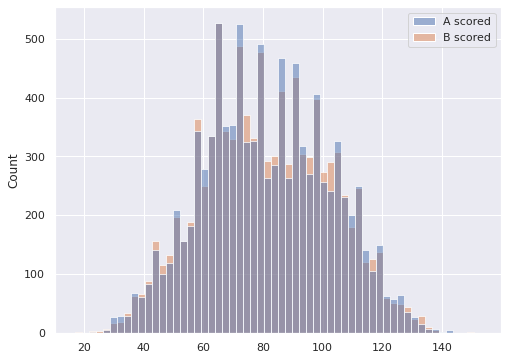

In [136]:
sns.set_theme()
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.histplot(data=tennis_df.loc[:, ['A scored', 'B scored']], ax=ax);

Vemos que a distribuição de probabilidade da quantidade de pontuação marcada foi extremamente semelhante, mostrando que o um valor de 0.5 para p nos fornece jogadores e, portanto, resultados próximos. É interessante observamos uma semelhança com a distribuição normal, como destacado na partida 1.

In [137]:
tennis_va3_dict = { 
    'A': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
    'B': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
}

for i in range(0, n_sample//3):
    tennis_va3_dict['A']['matches'].append(sum(tennis_df.iloc[i*3:i*3+3, :]['Winner'] == 'A'))
    tennis_va3_dict['B']['matches'].append(sum(tennis_df.iloc[i*3:i*3+3, :]['Winner'] == 'B'))

    tennis_va3_dict['A']['scored'].append(sum(tennis_df.loc[i*3:i*3+2, 'A scored']))
    tennis_va3_dict['B']['scored'].append(sum(tennis_df.loc[i*3:i*3+2, 'B scored']))

    tennis_va3_dict['A']['games'].append(sum(tennis_df.loc[i*3:i*3+2, 'games A-Wins']))
    tennis_va3_dict['B']['games'].append(sum(tennis_df.loc[i*3:i*3+2, 'games B-Wins']))

    tennis_va3_dict['A']['sets'].append(sum(tennis_df.loc[i*3:i*3+2, 'sets A-Wins']))
    tennis_va3_dict['B']['sets'].append(sum(tennis_df.loc[i*3:i*3+2, 'sets B-Wins']))

In [138]:
tennis_va3_df_dict = {
    'A': {
        'matches': pd.DataFrame(tennis_va3_dict['A']['matches']),
        'scored': pd.DataFrame(tennis_va3_dict['A']['scored']),
        'games': pd.DataFrame(tennis_va3_dict['A']['games']),
        'sets': pd.DataFrame(tennis_va3_dict['A']['sets'])
    },
    'B': {
        'matches': pd.DataFrame(tennis_va3_dict['B']['matches']),
        'scored': pd.DataFrame(tennis_va3_dict['B']['scored']),
        'games': pd.DataFrame(tennis_va3_dict['B']['games']),
        'sets': pd.DataFrame(tennis_va3_dict['B']['sets'])
    }}

In [139]:
# Média
tennis_va3_mean = {
    'A': [np.mean(i) for i in tennis_va3_dict['A'].values()],
    'B': [np.mean(i) for i in tennis_va3_dict['B'].values()]
}

tennis_va3_mean = pd.DataFrame(tennis_va3_mean).transpose()
tennis_va3_mean.columns = ['matches_mean', 'scored_mean', 'games_mean', 'sets_mean']
display(tennis_va3_mean)

# Desvio padrão
tennis_va3_std = {
    'A': [np.std(i) for i in tennis_va3_dict['A'].values()],
    'B': [np.std(i) for i in tennis_va3_dict['B'].values()]
}

tennis_va3_std = pd.DataFrame(tennis_va3_std).transpose()
tennis_va3_std.columns = ['matches_std', 'scored_std', 'games_std', 'sets_std']
display(tennis_va3_std)

,matches_mean,scored_mean,games_mean,sets_mean
A,1.509151,243.577558,36.164716,3.759976
B,1.490849,243.159916,36.000300,3.723372


,matches_std,scored_std,games_std,sets_std
A,0.867275,37.790115,6.574519,1.438819
B,0.867275,37.541487,6.552724,1.437251


Pela curva de distribuição normal, podiamos esperar os resultados acima, uma vez que ambas curvas foram extremamente semelhantes, as médias e desvios padrões também deveriam ser.

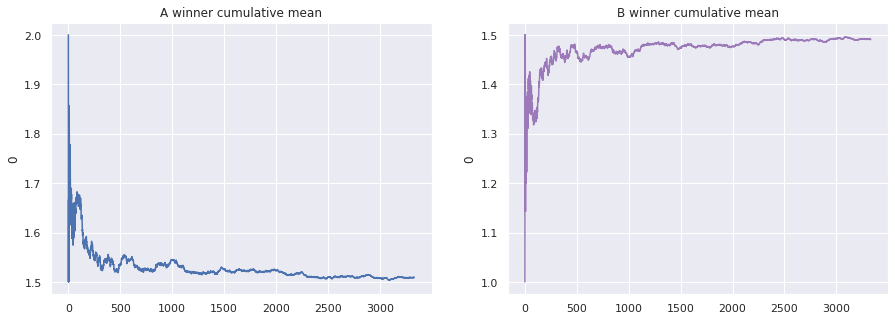

In [140]:
# Gráfico da média acumulada
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('A winner cumulative mean')
sns.lineplot(data=tennis_va3_df_dict['A']['matches'].expanding().mean().iloc[:, 0], ax=ax[0]);

ax[1].set_title('B winner cumulative mean')
sns.lineplot(data=tennis_va3_df_dict['B']['matches'].expanding().mean().iloc[:, 0], ax=ax[1], color='#9C7ABA');

Com valores medianos de p, obtemos curvas interessantes para a média acumulada. Nota-se que ao adicionarmos elementos no cálculo a média converge muito melhor, neste caso, tendendo para 1.5.

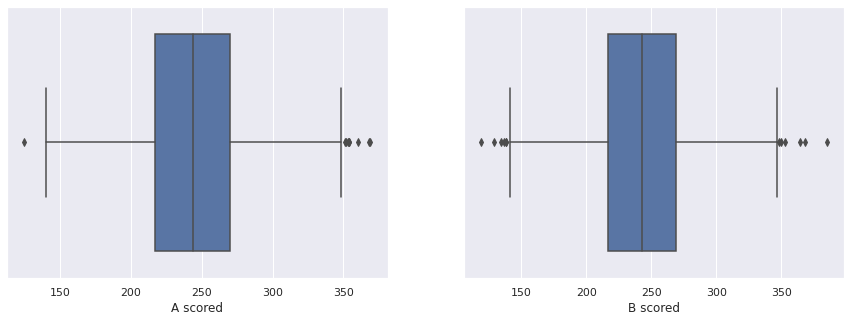

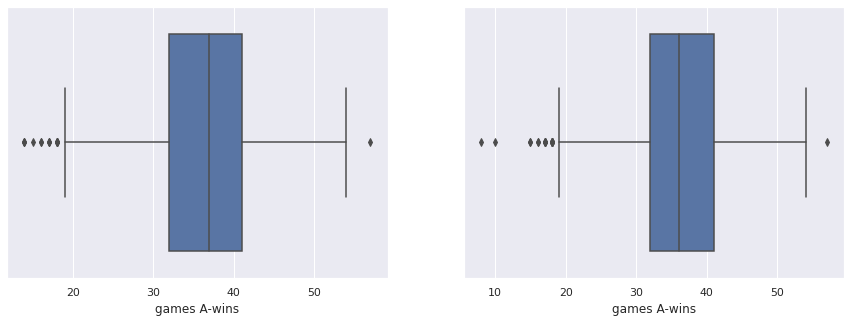

In [141]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va3_df_dict['A']['scored'][0], ax=ax[0]);
ax[0].set_xlabel('A scored')
sns.boxplot(x=tennis_va3_df_dict['B']['scored'][0], ax=ax[1]);
ax[1].set_xlabel('B scored')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va3_df_dict['A']['games'][0], ax=ax[0]);
ax[0].set_xlabel('games A-wins')
sns.boxplot(x=tennis_va3_df_dict['B']['games'][0], ax=ax[1]);
ax[1].set_xlabel('games A-wins');

Observa-se nos boxplots que os resultados foram muito simétricos, uma vez que os dados são fortemente influenciados pelas medidades de dispersão e tendência central e o valor de p impacta diretamente na difença de habilidade dos jogadores.

In [142]:
def percentage(data_a: pd.DataFrame, data_b: pd.DataFrame):
    data_a = data_a.sum()
    data_b = data_b.sum()
    return (data_a) / (data_a + data_b)

percentages = {}

percentages['scored'] = {
    'A': percentage(tennis_va3_df_dict['A']['scored'][0], tennis_va3_df_dict['B']['scored'][0]),
    'B': percentage(tennis_va3_df_dict['B']['scored'][0], tennis_va3_df_dict['A']['scored'][0])
}
percentages['games'] = {
    'A': percentage(tennis_va3_df_dict['A']['games'][0], tennis_va3_df_dict['B']['games'][0]),
    'B': percentage(tennis_va3_df_dict['B']['games'][0], tennis_va3_df_dict['A']['games'][0])
}
percentages['sets'] = {
    'A': percentage(tennis_va3_df_dict['A']['sets'][0], tennis_va3_df_dict['B']['sets'][0]),
    'B': percentage(tennis_va3_df_dict['B']['sets'][0], tennis_va3_df_dict['A']['sets'][0])
}
percentages['matches'] = {
    'A': percentage(tennis_va3_df_dict['A']['matches'][0], tennis_va3_df_dict['B']['matches'][0]),
    'B': percentage(tennis_va3_df_dict['B']['matches'][0], tennis_va3_df_dict['A']['matches'][0])
}

percentages_df = pd.DataFrame(percentages)
percentages_df

,scored,games,sets,matches
A,0.500429,0.501139,0.502446,0.50305
B,0.499571,0.498861,0.497554,0.49695


As porcentagens foram extremamente próximas, onde todas tendem à 50% como deveria ser esperado.

### VA com espaço amostral de 10 partidas

Assim como na análise da partida 1, devemos repetir os passos na análise da variável aleatória considerando um espaço amostral de 10 partidas.

In [143]:
tennis_va10_dict = { 
    'A': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
    'B': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
}

samples = np.random.randint(0, n_sample//10, (n_sample//10, 10))

for i in range(0, n_sample//10):
    tennis_va10_dict['A']['matches'].append(sum(tennis_df.iloc[samples[i], :]['Winner'] == 'A'))
    tennis_va10_dict['B']['matches'].append(sum(tennis_df.iloc[samples[i], :]['Winner'] == 'B'))

    tennis_va10_dict['A']['scored'].append(sum(tennis_df.loc[samples[i], 'A scored']))
    tennis_va10_dict['B']['scored'].append(sum(tennis_df.loc[samples[i], 'B scored']))

    tennis_va10_dict['A']['games'].append(sum(tennis_df.loc[samples[i], 'games A-Wins']))
    tennis_va10_dict['B']['games'].append(sum(tennis_df.loc[samples[i], 'games B-Wins']))

    tennis_va10_dict['A']['sets'].append(sum(tennis_df.loc[samples[i], 'sets A-Wins']))
    tennis_va10_dict['B']['sets'].append(sum(tennis_df.loc[samples[i], 'sets B-Wins']))

In [144]:
tennis_va10_df_dict = {
    'A': {
        'matches': pd.DataFrame(tennis_va10_dict['A']['matches']),
        'scored': pd.DataFrame(tennis_va10_dict['A']['scored']),
        'games': pd.DataFrame(tennis_va10_dict['A']['games']),
        'sets': pd.DataFrame(tennis_va10_dict['A']['sets'])
    },
    'B': {
        'matches': pd.DataFrame(tennis_va10_dict['B']['matches']),
        'scored': pd.DataFrame(tennis_va10_dict['B']['scored']),
        'games': pd.DataFrame(tennis_va10_dict['B']['games']),
        'sets': pd.DataFrame(tennis_va10_dict['B']['sets'])
    }}

In [145]:
# Média
tennis_va10_mean = {
    'A': [np.mean(i) for i in tennis_va10_dict['A'].values()],
    'B': [np.mean(i) for i in tennis_va10_dict['B'].values()]
}

tennis_va10_mean = pd.DataFrame(tennis_va10_mean).transpose()
tennis_va10_mean.columns = ['matches_mean', 'scored_mean', 'games_mean', 'sets_mean']
display(tennis_va10_mean)

# Desvio padrão
tennis_va10_std = {
    'A': [np.std(i) for i in tennis_va10_dict['A'].values()],
    'B': [np.std(i) for i in tennis_va10_dict['B'].values()]
}

tennis_va10_std = pd.DataFrame(tennis_va10_std).transpose()
tennis_va10_std.columns = ['matches_std', 'scored_std', 'games_std', 'sets_std']
display(tennis_va10_std)

,matches_mean,scored_mean,games_mean,sets_mean
A,5.086,813.332,120.919,12.471
B,4.914,811.880,120.034,12.423


,matches_std,scored_std,games_std,sets_std
A,1.611398,70.437488,12.404452,2.697250
B,1.611398,70.093620,12.174270,2.645009


As médias e desvios padrões, novamente mostram resultados sólidas e também a igualdade do nível técnico dos jogadores.

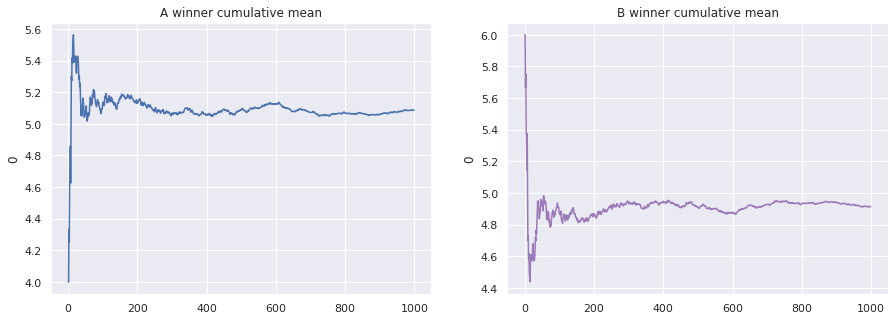

In [146]:
# Gráfico da média acumulada
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('A winner cumulative mean')
sns.lineplot(data=tennis_va10_df_dict['A']['matches'].expanding().mean().iloc[:, 0], ax=ax[0]);

ax[1].set_title('B winner cumulative mean')
sns.lineplot(data=tennis_va10_df_dict['B']['matches'].expanding().mean().iloc[:, 0], ax=ax[1], color='#9C7ABA');

Novamente, vemos que média acumulada converge com para mais dados, tendendo à 5, uma vez que pelo valor de p em 10 partidas a tendência é de que cada jogador vença 50%.

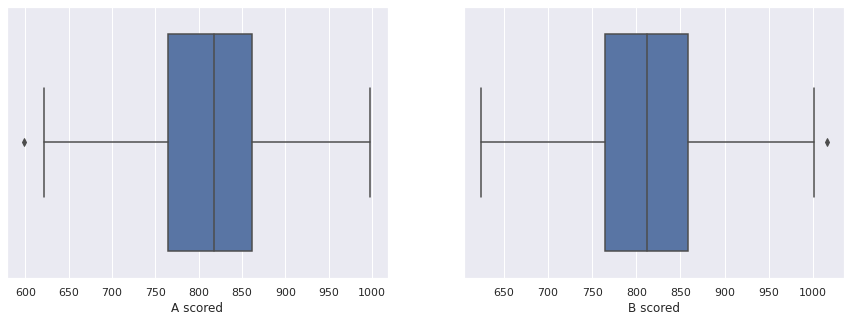

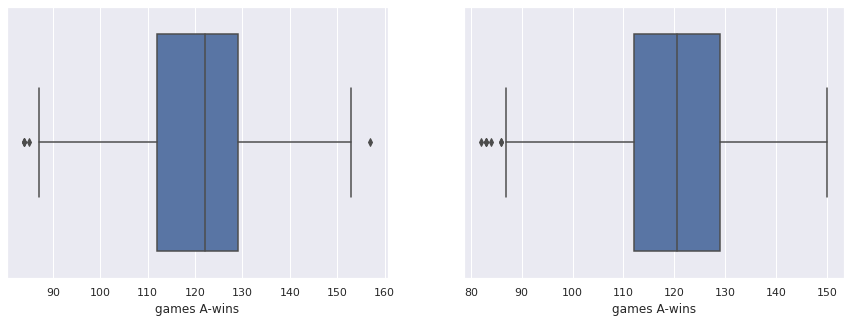

In [147]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va10_df_dict['A']['scored'][0], ax=ax[0]);
ax[0].set_xlabel('A scored')
sns.boxplot(x=tennis_va10_df_dict['B']['scored'][0], ax=ax[1]);
ax[1].set_xlabel('B scored')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va10_df_dict['A']['games'][0], ax=ax[0]);
ax[0].set_xlabel('games A-wins')
sns.boxplot(x=tennis_va10_df_dict['B']['games'][0], ax=ax[1]);
ax[1].set_xlabel('games A-wins');

In [148]:
def percentage(data_a: pd.DataFrame, data_b: pd.DataFrame):
    data_a = data_a.sum()
    data_b = data_b.sum()
    return (data_a) / (data_a + data_b)

percentages = {}

percentages['scored'] = {
    'A': percentage(tennis_va10_df_dict['A']['scored'][0], tennis_va10_df_dict['B']['scored'][0]),
    'B': percentage(tennis_va10_df_dict['B']['scored'][0], tennis_va10_df_dict['A']['scored'][0])
}
percentages['games'] = {
    'A': percentage(tennis_va10_df_dict['A']['games'][0], tennis_va10_df_dict['B']['games'][0]),
    'B': percentage(tennis_va10_df_dict['B']['games'][0], tennis_va10_df_dict['A']['games'][0])
}
percentages['sets'] = {
    'A': percentage(tennis_va10_df_dict['A']['sets'][0], tennis_va10_df_dict['B']['sets'][0]),
    'B': percentage(tennis_va10_df_dict['B']['sets'][0], tennis_va10_df_dict['A']['sets'][0])
}
percentages['matches'] = {
    'A': percentage(tennis_va10_df_dict['A']['matches'][0], tennis_va10_df_dict['B']['matches'][0]),
    'B': percentage(tennis_va10_df_dict['B']['matches'][0], tennis_va10_df_dict['A']['matches'][0])
}

percentages_df = pd.DataFrame(percentages)
percentages_df

,scored,games,sets,matches
A,0.500447,0.501836,0.500964,0.5086
B,0.499553,0.498164,0.499036,0.4914


Tanto o boxplot quanto as porcenagens não tiveram alterações significativas em relação ao espaço amostral de 3 partidas.

## Vários P

Uma análise interessante a ser feita é a influência da probabilidade p na chance de um jogador ganhar os pontos, games, sets e matches.

In [149]:
%%capture
def percentage(df: pd.DataFrame, column_a: str, column_b: str):
    data_a = df.loc[:, column_a].sum()
    data_b = df.loc[:, column_b].sum()
    return (data_a) / (data_a + data_b)

p_values = pd.DataFrame([])

for i in range(0, 1001):
    n_sample = 100
    p = i * 0.0009 + 0.1
    tennis_df = TenisSimulation.generate_dataset(p, n_sample)

    percentages = {}
    percentages['p'] = p
    percentages['games'] = {'A': percentage(tennis_df, 'games A-Wins', 'games B-Wins')}
    percentages['sets'] = {'A': percentage(tennis_df, 'sets A-Wins', 'sets B-Wins')}
    percentages['matches'] = {'A': tennis_df[tennis_df['Winner'] == 'A'].shape[0] / tennis_df.shape[0]}
    percentages['scores'] = {'A': percentage(tennis_df, 'A scored', 'B scored')}

    percentages_df = pd.DataFrame(percentages)
    p_values = pd.concat([p_values, percentages_df])

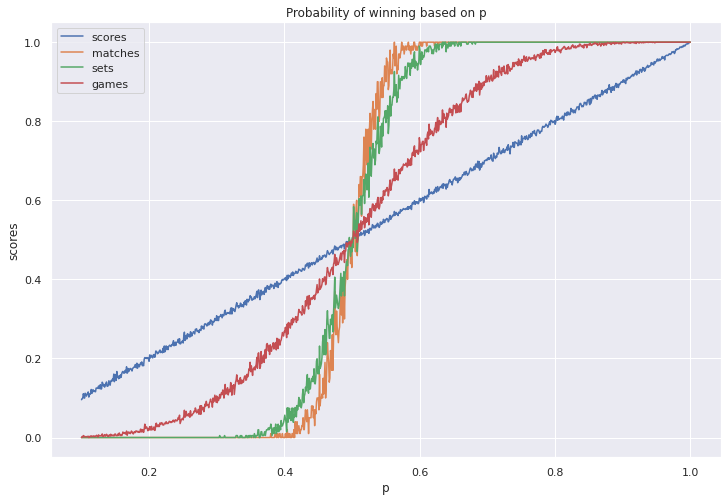

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title('Probability of winning based on p')
sns.lineplot(data=p_values.copy().reset_index(), x='p', y='scores', ax=ax, label='scores');
sns.lineplot(data=p_values.copy().reset_index(), x='p', y='matches', ax=ax, label='matches');
sns.lineplot(data=p_values.copy().reset_index(), x='p', y='sets', ax=ax, label='sets');
sns.lineplot(data=p_values.copy().reset_index(), x='p', y='games', ax=ax, label='games');

Observa-se que o valor p influência linearmente a quantidade de pontos marcados, como é de se esperar devido ao valor representar a chance do jogador A marcar o ponto em cada estado da cadeia.

Analisando o gráfico, percebemos a probabilidade de ganhar um ponto vai sendo propagada para os games, sets e posteriormente, os matches. Portanto, quanto maior a influência que um estado sofre pela variável p, isto é, a quantidade de p's necessários para calcular a probabilidade analiticamente, faz com que a curva tenha maior inclinação e mude de estado muito bruscamente de acordo com p.

Destaca-se que apesar da tendência das curvas serem claras, existem variações(aparência de gráfico rasbiscado) devido aos pontos terem sido obtidos através de simulações e não por métodos analíticos.